In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from numpy.linalg import inv
import scipy.signal

# First generate the data

In [2]:
#Generate data
dt = 0.001
alpha1 = 1.0
alpha2 = 1.5
alpha3 = 2.0

t = np.arange(0,1, dt)
N = len(t)
cp1 = int(0.35*N)
cp2 = int(0.85*N)

In [3]:
sample = np.zeros(len(t))
sample[:cp1] = alpha1*t[:cp1]+0.20*np.random.randn(cp1)
sample[cp1:cp2] = alpha2*(t[cp1:cp2]-t[cp1]) + 0.20*np.random.randn(cp2-cp1)
sample[cp2:] = alpha3*(t[cp2:]-t[cp2]) + 0.20*np.random.randn(N-cp2)

Looks pretty rough, I guess

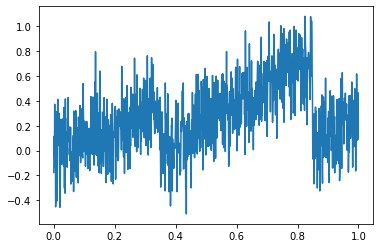

In [4]:
plt.plot(t, sample)

First thing we do is remove some noise without compromising on the jumps -- Savitzky-Golay is the way to go

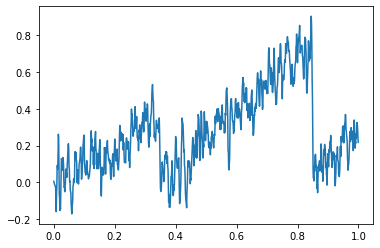

In [5]:
signal_smoothed = scipy.signal.savgol_filter(sample, 11, 2)
plt.plot(t, signal_smoothed)
sample=signal_smoothed

In [6]:
from numpy import dot
def kf_predict(X, P, A, Q, B, U):
    X = dot(A, X) + dot(B, U)
    P = dot(A, dot(P, A.T)) + Q
    return(X,P) 

from numpy import dot, sum, tile, linalg
from numpy.linalg import inv 

def kf_update(X, P, Y, H, R):
    IM = dot(H, X)
    IS = R + dot(H, dot(P, H.T))
    K = dot(P, dot(H.T, inv(IS)))
    X = X + dot(K, (Y-IM))
    P = P - dot(K, dot(IS, K.T))
    LH = log_gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)

def log_gauss_pdf(X, M, S):
    DX = X - tile(M, X.shape[1])
    E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
    E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(linalg.det(S))
    P = -E
    return E[0]

Now we apply it to the model, keeping in mind that we need to tune the R (observed noise covariance).

In [12]:
A = array([[1., dt ],  [0.,1.]])
X = array([[sample[0], np.random.randn()]]).T
Y = np.zeros((1,1))
P = diag((0.01, 0.01))
Q = eye(X.shape[0])
B = eye(X.shape[0])
U = zeros((X.shape[0],1))
H = array([[1.0, 0.0]])
R = 25.0*eye(1)

Predscore measures the log-likelihood of the next sample given the current best (kalman) prediction.  

In [13]:
N_iter = len(sample)
# Applying the Kalman Filter

filtered = np.zeros((N_iter, X.shape[0], X.shape[1]))
filteredIS = np.zeros((N_iter, Y.shape[0], Y.shape[1]))
filteredLH = np.zeros(N_iter)
predScore = np.zeros(N_iter)

for i in arange(0, N_iter-1):
    Y = np.array([[sample[i]]])
    (X, P) = kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    filtered[i, :, :] = X
    filteredIS[i, :, :] = IS
    filteredLH[i] = LH
    
    predScore[i] = (sample[i+1] - IM[0,0])**2 / (2*IS[0,0])

Orange is the filtered version

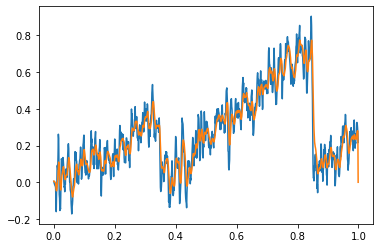

In [14]:
plt.plot(t, sample)
plt.plot(t, filtered[:,0,0])

Red lines denote true change points, peaks denote maximum discrepancy betwene KF prediction and data.  I dont know, probably too many tuning parameters to be useful.  Your milage may vary.

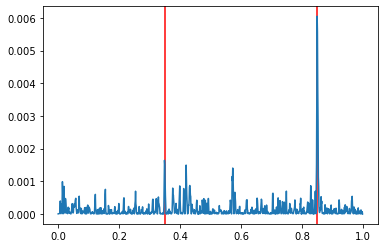

In [15]:
plt.axvline(t[cp1], color='red')
plt.axvline(t[cp2], color='red')
plt.plot(t, predScore)